<a href="https://colab.research.google.com/github/aguchhait-stack/NLTK/blob/main/Text_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   review_id                                             review
0          1  The instructions are confusing and hard to fol...
1          2  Great product! Helped me sleep better in just ...
2          3     The package arrived damaged and missing items.
3          4  Customer support was very helpful and resolved...
4          5    I love the taste and the packaging is nice too.
great        0.129538
confusing    0.100000
effective    0.100000
customer     0.100000
day          0.076190
advertise    0.076190
arrive       0.070711
cause        0.070711
damage       0.070711
effect       0.070711
dtype: float64


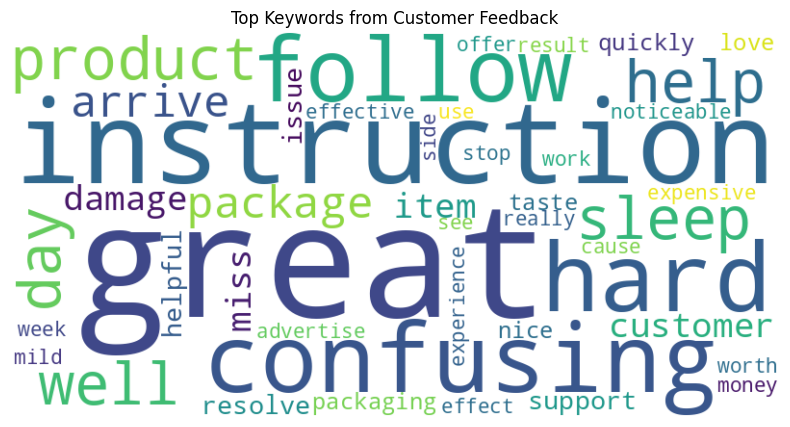

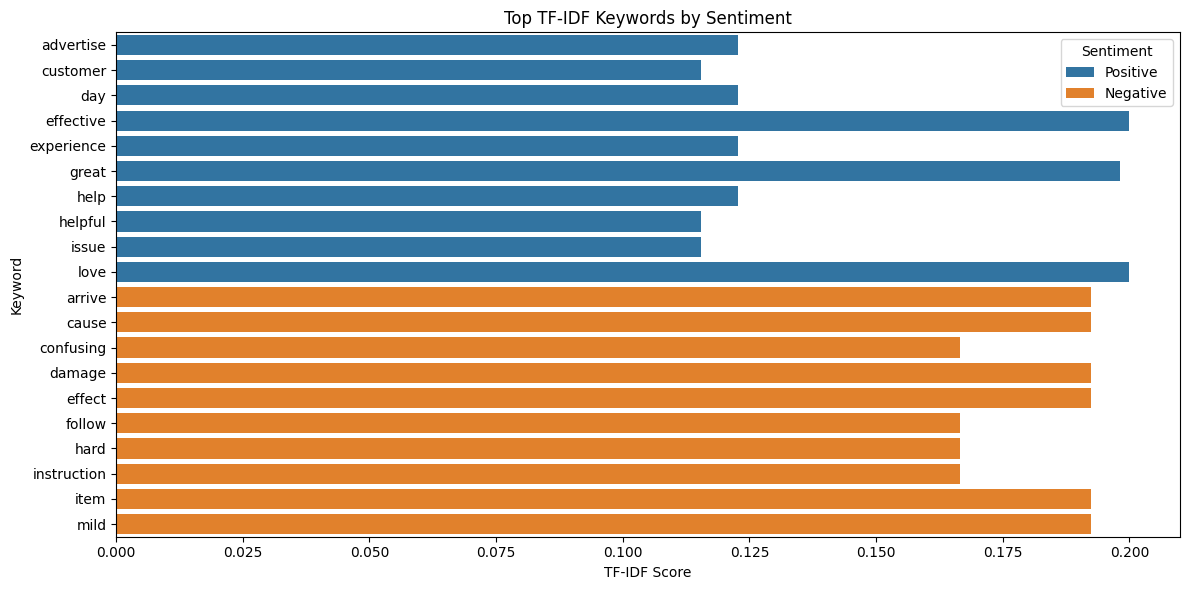

In [21]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r'https://raw.githubusercontent.com/aguchhait-stack/NLTK/refs/heads/main/customer_reviews.csv')  # fabricated dataset
df.dropna(subset=['review'], inplace=True)
print(df.head())

# Basic cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation
    text = text.lower()
    return text

df['cleaned'] = df['review'].apply(clean_text)

# Tokenization and lemmatization
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

def lemmatize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    return ' '.join(tokens)

df['lemmatized'] = df['cleaned'].apply(lemmatize)
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Get the sentiment score
df['sentiment'] = df['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Label it as Positive, Negative, or Neutral
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))
# Create the vectorizer
vectorizer = TfidfVectorizer(max_features=10)

# Fit and transform the text data
X = vectorizer.fit_transform(df['lemmatized'])

# View keywords
keywords_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(keywords_df.mean().sort_values(ascending=False))
# Combine all lemmatized reviews into a single string
text = ' '.join(df['lemmatized'])

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',  # or 'cool', 'plasma', etc.
    max_words=100
).generate(text)

# Plot it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Keywords from Customer Feedback")
plt.show()
# ----------------------------
# TF-IDF keywords by sentiment
# ----------------------------

def get_top_keywords(text_series, label):
    vectorizer = TfidfVectorizer(max_features=10)
    tfidf_matrix = vectorizer.fit_transform(text_series)
    avg_scores = tfidf_matrix.mean(axis=0).A1
    keywords = vectorizer.get_feature_names_out()
    return pd.DataFrame({'keyword': keywords, 'score': avg_scores, 'sentiment': label})

# Split by sentiment
positive_reviews = df[df['sentiment_label'] == 'Positive']['lemmatized']
negative_reviews = df[df['sentiment_label'] == 'Negative']['lemmatized']

# Extract keywords
pos_keywords = get_top_keywords(positive_reviews, 'Positive')
neg_keywords = get_top_keywords(negative_reviews, 'Negative')
combined_keywords = pd.concat([pos_keywords, neg_keywords])

# Plot TF-IDF keywords by sentiment
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_keywords, x='score', y='keyword', hue='sentiment')
plt.title("Top TF-IDF Keywords by Sentiment")
plt.xlabel("TF-IDF Score")
plt.ylabel("Keyword")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()




